In [0]:
import pandas as pd
import gc
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# For using MICE imputer  ignore if imputing values by other methods

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import Imputer
import numpy as np
import pandas as pd

class MiceImputer:
    
    model_dict_ = {}
    
    def __init__(self, seed_nulls=False, seed_strategy='mean'):
        self.seed_nulls = seed_nulls
        self.seed_strategy = seed_strategy
        
    
    def transform(self, X):
        col_order = X.columns
        new_X = []
        mutate_cols = list(self.model_dict_.keys())
        
        for i in mutate_cols:
            y = X[i]
            x_null = X[y.isnull()]
            y_null = y[y.isnull()].reset_index()['index']
            y_notnull = y[y.notnull()]
            
            model = self.model_dict_.get(i)
            
            if self.seed_nulls:
                x_null = model[1].transform(x_null)
            else:
                null_check = x_null.isnull().any()
                x_null = x_null[null_check.index[~null_check]]
            
            pred = pd.concat([pd.Series(model[0].predict(x_null))\
                              .to_frame()\
                              .set_index(y_null),y_notnull], axis=0)\
                              .rename(columns={0: i})
            
            new_X.append(pred)

        new_X.append(X[X.columns.difference(mutate_cols)])

        final = pd.concat(new_X, axis=1)[col_order]

        return final
        
        
    def fit(self, X):      
        x = X.fillna(value=np.nan)

        null_check = x.isnull().any()
        null_data = x[null_check.index[null_check]]
        
        for i in null_data:
            y = null_data[i]
            y_notnull = y[y.notnull()]

            model_list = []
            if self.seed_nulls:
                imp = Imputer(strategy=self.seed_strategy)
                model_list.append(imp.fit(x))
                non_null_data = pd.DataFrame(imp.fit_transform(x))
                
            else:
                non_null_data = x[null_check.index[~null_check]]
                
            
            x_notnull = non_null_data[y.notnull()]
            
            if y.nunique() > 2:
                model = LinearRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})
            else:
                model = LogisticRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})

        return self
        

    def fit_transform(self, X):
        return self.fit(X).transform(X)


In [0]:
train = pd.read_csv('/content/drive/My Drive/ASHRAE/train.csv')
weather_train = pd.read_csv('/content/drive/My Drive/ASHRAE/weather_train.csv')
build_metadata = pd.read_csv('/content/drive/My Drive/ASHRAE/building_metadata.csv')


In [0]:
print(train.shape)
print(build_metadata.shape)
print(weather_train.shape)


(20216100, 4)
(1449, 6)
(139773, 9)


In [0]:
# Changing the domain to log values


#build_metadata['square_feet'] = np.log(build_metadata['square_feet'])

In [0]:
print(train.shape)
print(build_metadata.shape)
print(weather_train.shape)

(20216100, 4)
(1449, 6)
(139773, 9)


In [0]:
weather_train['air_temperature'].fillna(method = 'ffill',inplace = True)
weather_train['dew_temperature'].fillna(method = 'ffill',inplace = True)

In [0]:
weather_train['sea_level_pressure'].fillna(method = 'ffill',inplace = True)
weather_train['wind_speed'].fillna(method = 'ffill',inplace = True)

In [0]:
weather_train.drop(['cloud_coverage','precip_depth_1_hr','wind_direction'],axis=1,inplace = True)
weather_train.isnull().sum()

site_id               0
timestamp             0
air_temperature       0
dew_temperature       0
sea_level_pressure    0
wind_speed            0
dtype: int64

In [0]:
build_metadata.drop(['year_built','floor_count'],axis = 1,inplace = True)

In [0]:
train_data = train.merge(build_metadata, on="building_id", how="left")

In [0]:
train_data = train_data.merge(weather_train, on=["site_id", "timestamp"], how="left")


In [0]:
train_data.isnull().sum()

building_id               0
meter                     0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
air_temperature       90495
dew_temperature       90495
sea_level_pressure    90495
wind_speed            90495
dtype: int64

In [0]:
train_data['air_temperature'].fillna(method = 'ffill',inplace = True)
train_data['dew_temperature'].fillna(method = 'ffill',inplace = True)

In [0]:
train_data['sea_level_pressure'].fillna(method = 'ffill',inplace = True)
train_data['wind_speed'].fillna(method = 'ffill',inplace = True)

In [0]:
train_data.isnull().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
dew_temperature       0
sea_level_pressure    0
wind_speed            0
dtype: int64

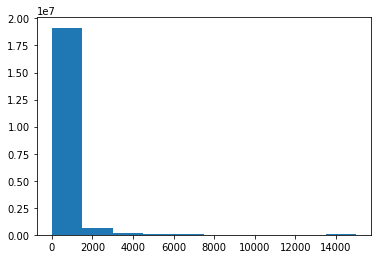

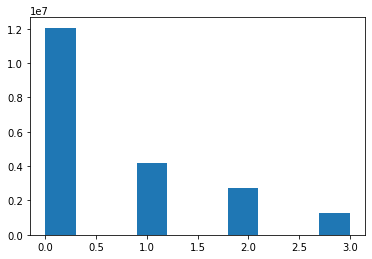

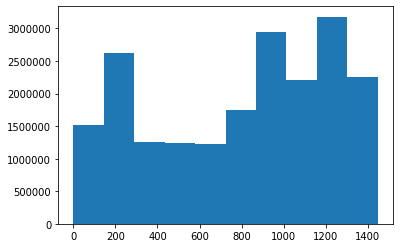

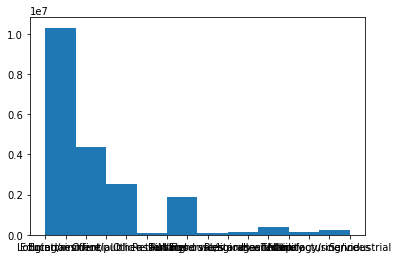

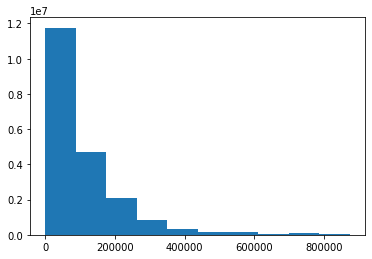

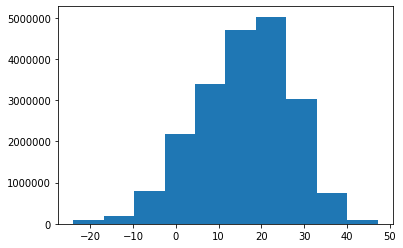

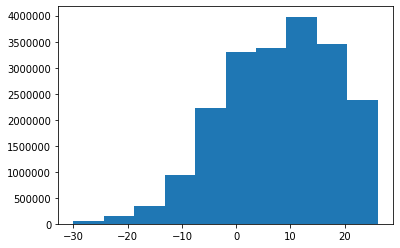

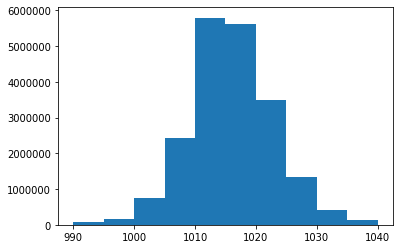

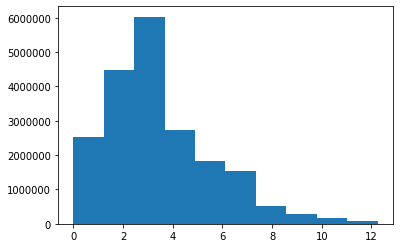

In [0]:
# Removing the outliers
train_data.loc[train_data['meter_reading']>6400,'meter_reading'] = 6400

train_data.loc[train_data['air_temperature']<-24,'air_temperature']=-24
train_data.loc[train_data['air_temperature']>48,'air_temperature']=48
train_data.loc[train_data['dew_temperature']<-30,'dew_temperature']=-30
train_data.loc[train_data['sea_level_pressure']<990,'sea_level_pressure']=990
train_data.loc[train_data['sea_level_pressure']>1040,'sea_level_pressure']=1040
train_data.loc[train_data['wind_speed']>12.25,'wind_speed']=12.25
#train_data.loc[train_data['square_feet']>800000,'square_feet']=800000
plt.hist(train_data['meter_reading'])
plt.show()                             
plt.hist(train_data['meter'])
plt.show()
plt.hist(train_data['building_id'])
plt.show()
plt.hist(train_data['primary_use'])
plt.show()
plt.hist(train_data['square_feet'])
plt.show()
plt.hist(train_data['air_temperature'])
plt.show()
plt.hist(train_data['dew_temperature'])
plt.show()
plt.hist(train_data['sea_level_pressure'])
plt.show()
plt.hist(train_data['wind_speed'])
plt.show()




In [0]:

del train
# deleting so as to prevent session crash due to RAM overflow
del build_metadata
del weather_train
gc.collect()

27834

In [0]:
train_data['square_feet'] = np.log(train_data['square_feet'])


In [0]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
train_data.timestamp = pd.to_datetime(train_data.timestamp, format="%Y-%m-%d %H:%M:%S")
  
train_data["hour"] = train_data.timestamp.dt.hour
train_data["month"]= train_data.timestamp.dt.month
train_data["weekday"] = train_data.timestamp.dt.weekday
train_data["is_holiday"] = (train_data.timestamp.isin(holidays)).astype(int)


In [0]:
train_data.drop(['timestamp'],axis=1,inplace = True)

In [0]:
train_data.shape

(20216100, 14)

In [0]:
train_data.isnull().sum()

building_id           0
meter                 0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
dew_temperature       0
sea_level_pressure    0
wind_speed            0
hour                  0
month                 0
weekday               0
is_holiday            0
dtype: int64

In [0]:
correlation = train_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,cmap = 'RdYlGn')

In [0]:
train_data.head()

In [0]:
p1 = train_data['building_id']*train_data['meter']
p2 = train_data['square_feet']/train_data['sea_level_pressure']
p3 = train_data['air_temperature']+train_data['dew_temperature']
p5 = train_data['site_id']
p6 = train_data['meter_reading']

In [0]:
df = pd.concat([p1,p2,p3,p5,p6,train_data['meter_reading']],axis = 1)
del p1,p2,p3,p5,p6
gc.collect()

39

In [0]:
df = df.iloc[:,:-1]
df.head(10)

0         1     2  site_id  meter_reading
0  0  0.008741  45.0        0            0.0
1  0  0.007756  45.0        0            0.0
2  0  0.008424  45.0        0            0.0
3  0  0.009878  45.0        0            0.0
4  0  0.011441  45.0        0            0.0
5  0  0.008814  45.0        0            0.0
6  0  0.010040  45.0        0            0.0
7  0  0.011478  45.0        0            0.0
8  0  0.010803  45.0        0            0.0
9  0  0.010006  45.0        0            0.0

In [0]:
pf = train_data#[train_data['site_id']==1]
tf = df#[df['site_id']==1]
#correlation = tf.corr()
#plt.figure(figsize=(20,20))
#sns.heatmap(correlation,annot=True)

In [0]:
#tf.drop(['site_id'],axis=1,inplace = True)

pf.drop(['site_id','meter_reading'],axis=1,inplace = True)
pf = pd.concat([pf,tf],axis = 1)

In [0]:
pf.tail(5)

In [0]:
correlation = pf.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True)

In [0]:
le = LabelEncoder()
pf['primary_use'] = le.fit_transform(pf['primary_use'])


In [0]:
X = pf.iloc[:,:-1]
y = pf.iloc[:,-1]
#X.head()


In [0]:
y.head()

In [0]:
print( str(X.shape[0]) + '  ' + str(y.shape[0]))

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42)

In [0]:
X_train.head()

In [0]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [0]:


sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)




In [0]:
sc_Y = StandardScaler()
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train = sc_Y.fit_transform(y_train)
y_test = sc_Y.fit_transform(y_test)
y_train = y_train[:,0]
y_test = y_test[:,0]

0

In [0]:
# Fitting XGBoost to the Training set
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train,verbose=1000,eval_set = [(X_test,y_test)],early_stopping_rounds = 200)

In [0]:
#XGB
y_pred = sc_y.inverse_transform(regressor.predict(X_test))


In [0]:
#XGB
r2 = r2_score(y_test,y_pred)
r2

In [0]:
#LGBM
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test,y_test)

In [0]:
#LGBM
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['device'] = 'cpu'
params['num_leaves'] = 256
params['min_data'] = 50
params['max_depth'] = 32
clf = lgb.train(params, d_train, 15000,valid_sets = d_test,early_stopping_rounds=100)

[1]	valid_0's l2: 0.98456
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 0.979962
[3]	valid_0's l2: 0.973069
[4]	valid_0's l2: 0.960722
[5]	valid_0's l2: 0.953895
[6]	valid_0's l2: 0.938693
[7]	valid_0's l2: 0.937911
[8]	valid_0's l2: 0.924845
[9]	valid_0's l2: 0.917716
[10]	valid_0's l2: 0.906561
[11]	valid_0's l2: 0.895756
[12]	valid_0's l2: 0.884431
[13]	valid_0's l2: 0.87062
[14]	valid_0's l2: 0.857376
[15]	valid_0's l2: 0.851039
[16]	valid_0's l2: 0.838651
[17]	valid_0's l2: 0.827092
[18]	valid_0's l2: 0.814267
[19]	valid_0's l2: 0.801773
[20]	valid_0's l2: 0.789222
[21]	valid_0's l2: 0.777034
[22]	valid_0's l2: 0.765171
[23]	valid_0's l2: 0.75604
[24]	valid_0's l2: 0.744786
[25]	valid_0's l2: 0.740248
[26]	valid_0's l2: 0.729373
[27]	valid_0's l2: 0.724773
[28]	valid_0's l2: 0.71427
[29]	valid_0's l2: 0.705682
[30]	valid_0's l2: 0.699311
[31]	valid_0's l2: 0.690278
[32]	valid_0's l2: 0.68404
[33]	valid_0's l2: 0.673995
[34]	valid_0's l2: 0.664181

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostRegressor




In [0]:
#CAT
cat = CatBoostRegressor(num_trees = 9000, task_type = 'GPU',devices = '0:1:2', depth = 12)
cat.fit(X_train,y_train,eval_set =(X_test,y_test) ,early_stopping_rounds=1200)

In [0]:
#CAT
y_pred = cat.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
print( 'R_squared value :' + str(r2) + ' Mean Squared Error : ' + str(mse) )

R_squared value :0.8611249741652636 Mean Squared Error : 80238.04297142179


In [0]:
del df
del pf
del y
del tf
del train_data
del X_train
del y_train
del y_test
del X_test
gc.collect()

231

In [0]:

filename = 'lgb15000.sav'
pickle.dump(clf, open(filename, 'wb'))

In [0]:
build_metadata = pd.read_csv('/content/drive/My Drive/ASHRAE/building_metadata.csv')
weather_test = pd.read_csv('/content/drive/My Drive/weather_test.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

In [0]:
build_metadata.drop(['year_built','floor_count'],axis = 1,inplace = True)

In [0]:
train_data = test.merge(build_metadata, on="building_id", how="left")

In [0]:
train_data = train_data.merge(weather_test, on=["site_id", "timestamp"], how="left")

In [0]:
del test
         # deleting so as to prevent session crash due to RAM overflow
del build_metadata
del weather_test
gc.collect()


0

In [0]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
train_data.timestamp = pd.to_datetime(train_data.timestamp, format="%Y-%m-%d %H:%M:%S")
  
train_data["hour"] = train_data.timestamp.dt.hour
train_data["month"]= train_data.timestamp.dt.month
train_data["weekday"] = train_data.timestamp.dt.weekday
train_data["is_holiday"] = (train_data.timestamp.isin(holidays)).astype(int)

In [0]:
train_data.drop(['timestamp'],axis=1,inplace = True)

In [0]:
train_data['square_feet'] = np.log(train_data['square_feet'])

In [0]:
train_data.head()

In [0]:
train_data.drop(['cloud_coverage','precip_depth_1_hr'],axis=1,inplace = True)

In [0]:
train_data['air_temperature'].fillna(method = 'ffill',inplace = True)
train_data['dew_temperature'].fillna(method = 'ffill',inplace = True)

In [0]:
train_data['sea_level_pressure'].fillna(method = 'ffill',inplace = True)
train_data.drop(['wind_direction'],axis=1,inplace = True)
train_data['wind_speed'].fillna(method = 'ffill',inplace = True)

In [0]:
p1 = train_data['building_id']*train_data['meter']
p2 = train_data['square_feet']/train_data['sea_level_pressure']
p3 = train_data['air_temperature']+train_data['dew_temperature']
p4 = np.log(train_data.square_feet)
p5 = train_data['site_id']


In [0]:
dft = pd.concat([p1,p2,p3,p4,p5],axis = 1)

In [0]:
dft.head()

In [0]:
pft = train_data#[train_data['site_id']==1]
tft = dft#[df['site_id']==1]
#correlation = tf.corr()
#plt.figure(figsize=(20,20))
#sns.heatmap(correlation,annot=True)

In [0]:
tft.head()

In [0]:

pft.drop(['site_id'],axis=1,inplace = True)
pft = pd.concat([pft,tft],axis = 1)

In [0]:
pft.head()

In [0]:
del p1,p2,p3,p4,p5,tft,dft,train_data 
gc.collect()

34

In [0]:
le = LabelEncoder()
pft['primary_use'] = le.fit_transform(pft['primary_use'])


In [0]:
pft.isnull().sum()

In [0]:
X_TEST = pft
del pft
gc.collect()

0

In [0]:
X_TEST.drop(['row_id'],axis = 1,inplace = True)

In [0]:
X_TEST = X_TEST.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16]]

X_TEST.head()

In [0]:
X.head()

In [0]:
X_TEST = X_TEST.values

In [0]:
X_TEST = sc_X.transform(X_TEST)

In [0]:
regressor = pickle.load(open('lgb15000.sav', 'rb'))

In [0]:
y_pred = sc_Y.inverse_transform(regressor.predict(X_TEST))

In [0]:
del X_TEST


In [0]:
y_pred = pd.DataFrame(y_pred)

In [0]:
y_pred.to_csv('submit_lgb.csv',index=False)